In [25]:
import pandas as pd 
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

from euphonic import Quantity,ForceConstants,ureg
from euphonic.plot import plot_1d
from scipy.optimize import curve_fit
from scipy.integrate import simps
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D


In [8]:
fc = ForceConstants.from_phonopy(path='../results/qe/fdm/results/',
                                 summary_name='phonopy.yaml')
cell = fc.crystal.to_spglib_cell()
qpts = pd.read_csv("../data/kpoints.csv")[["x","y","z"]].values
data_list=list()
for i, (start,end) in enumerate(zip(qpts[:-1],qpts[1:])):
        data_list+=list(np.linspace(start,end))
        
df_qpoints=pd.DataFrame(data_list).drop_duplicates()

# Calculate frequencies/eigenvectors
phonons = fc.calculate_qpoint_phonon_modes(df_qpoints.values, asr='reciprocal')
phonons.crystal.atom_type=[{"Fe1":"Fe","Fe2":"Fe","O":"O"}[x] for x in phonons.crystal.atom_type]

Force constants not found in ../results/qe/fdm/results/phonopy.yaml, attempting to read from ../results/qe/fdm/results/FORCE_CONSTANTS


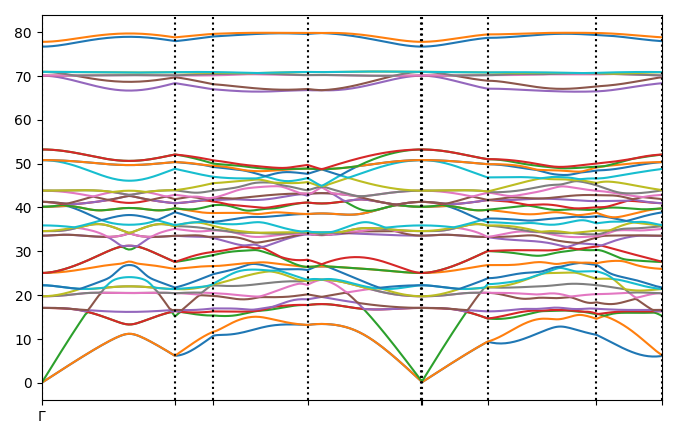

In [9]:
bands = phonons.get_dispersion()  # type: Spectrum1DCollection
# Create an array of energy bins 0 - 20 in meV
fig = plot_1d(bands)
fig.set_size_inches(8,5)
ax1,ax2=fig.get_axes()
xtics=ax1.get_xticks()
xticklabels=ax1.get_xticklabels()
n=[ax1.axvline(xx,c="black",ls="dotted") for xx in xtics]

In [10]:


# Fit the resolution data to a polynomial for extrapolation
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Create a function to get resolution for any energy
def get_resolution(e,popt):
    return np.maximum(poly_func(e, *popt), 1e-10)  # Ensure non-zero resolution


# Perform Gaussian broadening using convolution with energy-dependent widths
def gaussian_broadening(dos, energy, sigmas):
    broadened_dos = np.zeros_like(dos)
    for i in range(len(energy)):
        # Create a Gaussian kernel centered at each energy point with width sigmas[i]
        kernel = np.exp(-0.5 * ((energy - energy[i]) / sigmas[i])**2)
        kernel /= simps(kernel, energy)  # Normalize the kernel to preserve area
        broadened_dos += dos[i] * kernel  # Convolve DOS with Gaussian kernel
    return broadened_dos

def apply_gaussian_broadening(dos_data,metric='dos total (nm2/ps)',unit_cell_atoms=1):
    energy = dos_data['Energy Transfer (meV)'].values
    dos = dos_data[metric].values

    resolution_data = pd.read_csv('../data/experiment/resolution.csv')
    res_energy = resolution_data['Energy (meV)'].values
    resolution = resolution_data['Resolution'].values
    popt, _ = curve_fit(poly_func, res_energy, resolution)
    
    # Create an array of sigmas for Gaussian broadening based on the resolution function
    sigmas = get_resolution(energy,popt) / np.sqrt(8 * np.log(2))  # Convert FWHM to sigma


    broadened_dos = gaussian_broadening(dos, energy, sigmas)

    # Area normalize both original and broadened DOS
    original_area = simps(dos, energy)
    broadened_area = simps(broadened_dos, energy)

    dos_normalized = dos / original_area
    broadened_dos_normalized = broadened_dos / broadened_area
    return 3*unit_cell_atoms*broadened_dos_normalized

In [17]:
results_directory={"../results/gromacs/bulk/results/md_phonon_200/":"bulk"
                  }
df_list=list()

min_energy=0
max_energy=150

for data_directory,radius in results_directory.items():
    for filename in os.listdir(data_directory):
        if not "dos.h5" in filename:
            continue
        print(os.path.join(data_directory,filename))
        h5file=h5py.File(os.path.join(data_directory,filename))
        data_dict=dict()
        omega_shape=h5file["omega"][:].shape
        for k in h5file.keys():
            data_array=h5file[k][:]
            if data_array.shape != omega_shape or "_0" in k:
                continue
            units=h5file[k].attrs['units']
            data_dict["%s (%s)"%(k.replace("_"," "),units)]=data_array
        df_tmp=pd.DataFrame(data_dict).query("%f < `omega (rad/ps)` and `omega (rad/ps)` < %f"%(min_energy/0.6582,max_energy/0.6582))
        directory_split=data_directory.split("/")
        system=directory_split[3]
        df_tmp["Weight"]=" ".join(filename.split("_")[:-1]).replace('b ','').capitalize()
        df_tmp["Method"]="MD"
        df_tmp["Force Field"]="LJ"
        df_tmp["Energy Transfer (meV)"]=df_tmp["omega (rad/ps)"]*0.6582
        df_tmp["Normalized Count"]=apply_gaussian_broadening(df_tmp)
        for species in ["Fe","O"]:
            df_tmp[species]=apply_gaussian_broadening(df_tmp,"dos %s (nm2/ps)"%species)
            df_tmp[species]/=df_tmp[species].max()
        df_tmp["Max Normalized Count"]=df_tmp["Normalized Count"]/df_tmp["Normalized Count"].max()
        df_tmp["Radius (nm)"]=radius
        df_tmp["Software"]=directory_split[2]
        df_tmp["System"]=system #.split("_")[0].replace("nanoparticle", "np")
        
        df_list.append(df_tmp)
        
df_dos_gromacs=pd.concat(df_list,ignore_index=True)

../results/gromacs/bulk/results/md_phonon_200/b_coherent_dos.h5
../results/gromacs/bulk/results/md_phonon_200/b_incoherent_dos.h5


/home/galavizp/.local/lib/python3.8/site-packages/pandas/core/construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
/home/galavizp/.local/lib/python3.8/site-packages/pandas/core/construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


,Energy Transfer (meV),Max Normalized Count,Fe,O,Method,Weight
0,0.0,0.031230,0.031175,0.011021,DFT,Incoherent
1,0.1,0.032505,0.032448,0.011470,DFT,Incoherent
2,0.2,0.033791,0.033731,0.011923,DFT,Incoherent
3,0.3,0.035084,0.035023,0.012378,DFT,Incoherent
4,0.4,0.036383,0.036319,0.012835,DFT,Incoherent
...,...,...,...,...,...,...
1494,149.4,0.000000,0.000000,0.000000,DFT,Coherent
1495,149.5,0.000000,0.000000,0.000000,DFT,Coherent
1496,149.6,0.000000,0.000000,0.000000,DFT,Coherent
1497,149.7,0.000000,0.000000,0.000000,DFT,Coherent


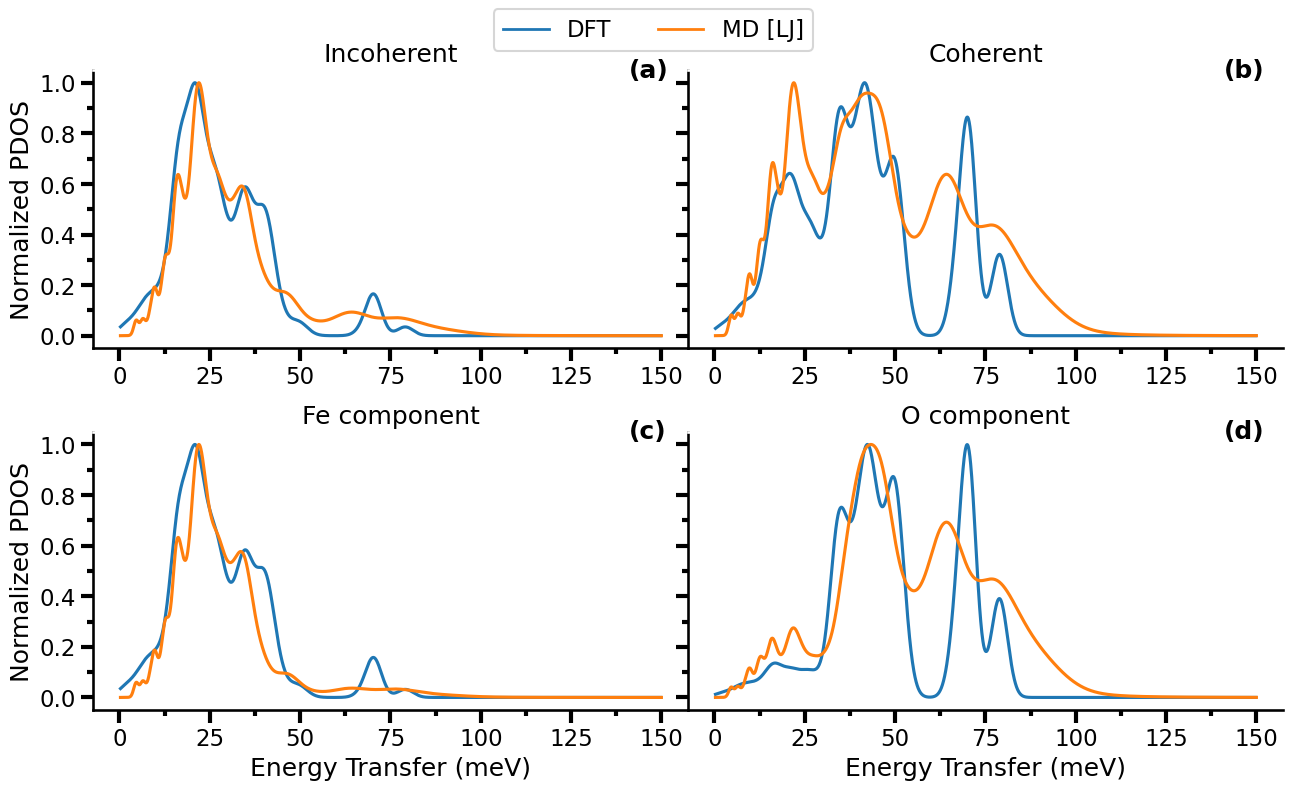

In [26]:

energy_bins = np.arange(0, 150, 0.1)*ureg('meV')
# Calculate dos
broaden=5
df_list=list()
for weight in ['incoherent','coherent']:
    pdos = phonons.calculate_pdos(energy_bins, weighting=weight)  # atom resolved pdos
    species_pdos = pdos.group_by('species')  # species resolved pdos
    broadened_species_spectrum=species_pdos.broaden(broaden*ureg('meV'))
    total_dos = pdos.sum()  # total dos
    broadened_spectrum=total_dos.broaden(broaden*ureg('meV'))


    df_tmp=pd.DataFrame({"Energy Transfer (meV)":broadened_species_spectrum.x_data[:-1]
                                 ,"Max Normalized Count":broadened_spectrum.y_data/np.max(broadened_spectrum.y_data) 
                                ,"Fe":broadened_species_spectrum.y_data[0]/np.max(broadened_species_spectrum.y_data[0])                        
                                ,"O":broadened_species_spectrum.y_data[1]/np.max(broadened_species_spectrum.y_data[1])
                               })
    df_tmp["Method"]="DFT"
    df_tmp["Weight"]=weight.capitalize()
    df_list.append(df_tmp)
df_dos_dft=pd.concat(df_list)
display(df_dos_dft)


fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(7*2,4*2))
sns.set_context("talk")
palette=sns.color_palette("tab10")

labx=0.9
laby=0.975
emin,emax=0.25,150
index=["(%s)"%x for x in list("abcd")]


for i, k1 in enumerate(np.reshape(["Incoherent","Coherent","Fe","O"],(2,2))):
    for j,v in enumerate(k1):
        ax=axs[i,j]
        ax.text(labx, laby, index[2*i+j],weight='bold' ,transform=ax.transAxes)
        weight = v if i==0 else "Coherent"
        yvariable = v if i>0 else 'Max Normalized Count'
        sns.lineplot(data=df_dos_dft.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and Weight== '%s'"%(emin,emax,weight))
                    ,y=yvariable
                    ,x='Energy Transfer (meV)'
                    ,ax=ax
                   ,color=palette[0]
               )

        sns.lineplot(data=df_dos_gromacs.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and Weight== '%s' "%(emin,emax,weight))
                    ,y=yvariable
                    ,x='Energy Transfer (meV)'
                    ,ax=ax
                   ,color=palette[1]
               )

        ax.spines['bottom'].set_color('0')
        ax.spines['top'].set_color('1')
        ax.spines['right'].set_color('1')
        ax.spines['left'].set_color('0')
        ax.tick_params(direction='out', width=3, bottom=True, left=True)
        ax.grid(False)
        ax.set_ylabel("Normalized PDOS")
        ax.xaxis.set_minor_locator(MultipleLocator(25/2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))
        ax.tick_params(which='minor', length=4, width=3)

        if j > 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])
        if i == 0:
            ax.set_xlabel("")
        if i > 0:
            ax.set_title("%s component"%v,y=1)
        else:
            ax.set_title(v,y=1)
            
custom_lines = [Line2D([0], [0], color=palette[0], lw=2)
                ,Line2D([0], [0], color=palette[1], lw=2)]
ax.legend(custom_lines,["DFT","MD [LJ]"])
sns.move_legend(ax,'center',bbox_to_anchor=(0.5,0.95),ncol=2,bbox_transform=fig.transFigure)


            
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.95, 
                    top=0.9, 
                    wspace=0., 
                    hspace=0.3
                   )

plt.savefig("../figures/fig4.pdf", pad_inches=0.2,bbox_inches="tight")